In [1]:
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from itertools import combinations_with_replacement

sys.path.insert(0,'../DEC-keras')
from DEC import DEC, ClusteringLayer

from sklearn.metrics import f1_score, roc_curve
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.initializers import Initializer
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum):
  dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
  ae_weights = ae_weights
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=ae_weights,
                       x=x, loss='kld')
  dec.load_weights(dec_weights)
  dec.model.summary()
  return dec

In [3]:
def get_cluster_to_label_mapping(y, y_pred, n_classes, n_clusters):

  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = []
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

In [4]:
def get_cluster_to_label_mapping_safe(y, y_pred, n_classes, n_clusters):
  """Enusre at least one cluster assigned to each label.
  """
  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = []
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  #print(cluster_to_label_mapping)

  print(np.unique(y), np.unique(cluster_to_label_mapping))
  try:
    # make sure there is at least 1 cluster representing each class
    assert np.all(np.unique(y) == np.unique(cluster_to_label_mapping))
  except AssertionError:
    # if there is no cluster for a class then we will assign a cluster to that
    # class
    
    # find which class it is
    # ASSUMPTION - this task is binary
    
    diff = list(set(np.unique(y)) - set(np.unique(cluster_to_label_mapping)))[0]
      # we choose the cluster that contains the most examples of the class with no cluster
      
    one_hot = np_utils.to_categorical(y_pred[np.where(y==diff)[0]], \
                                        len(cluster_to_label_mapping))
                                      
    cluster_to_label_mapping[np.argmax(np.sum(one_hot, axis=0))] = int(diff)
  print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

In [5]:
def all_same(items):
  return all(x == items[0] for x in items)

In [6]:
def get_best_mapping(y, predicted_clusters, n_clusters, fom):
  best_metric = 0
  best_mapping = []
  for cluster_to_label_mapping in combinations_with_replacement([0,1], n_clusters):
    if all_same(cluster_to_label_mapping):
      continue
    metric = fom(y, predicted_clusters, cluster_to_label_mapping)
    if metric >= best_metric:
      best_metric = metric
      best_mapping = cluster_to_label_mapping
  return best_metric, best_mapping

In [7]:
def get_cluster_centres(dec):
  return np.squeeze(np.array(dec.model.get_layer(name='clustering').get_weights()))

In [8]:
def pca_plot(base_network, x, cluster_centres, y=None, labels=[], \
             lcolours=[], ulcolour='#747777', ccolour='#4D6CFA'):
    
  pca = PCA(n_components=2)
  x_pca = pca.fit_transform(base_network.predict(x))
  c_pca = pca.transform(cluster_centres)
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  if np.any(y):
    unique_targets = list(np.unique(y))
    if -1 in unique_targets:
      ax.scatter(x_pca[np.where(y==-1),0], x_pca[np.where(y==-1),1], marker='o', s=20, \
        color=ulcolour, alpha=0.1)
      unique_targets.remove(-1)
    for l in unique_targets:
        ax.scatter(x_pca[np.where(y==l),0], x_pca[np.where(y==l),1], \
          marker='o', s=5, color=lcolours[l], alpha=0.5, label=labels[l])
  else:
    ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, \
      color=ulcolour, alpha=0.1)
  ax.scatter(c_pca[:,0], c_pca[:,1], marker='o', s=40, color=ccolour, \
    alpha=1.0, label='cluster centre')

  for i in range(len(cluster_centres)):
    ax.text(c_pca[i,0], c_pca[i,1], str(i), size=20)
  plt.axis('off')
  plt.show()

In [9]:
'''
class MapInitializer(Initializer):
    
  def __init__(self, mapping, n_classes):
    self.mapping = mapping
    self.n_classes = n_classes

  def __call__(self, shape, dtype=None):
    #return K.one_hot(self.mapping, self.n_classes)
    #return K.ones(shape=(100,10))
    #print(K.eval(K.cast(K.one_hot(self.mapping, self.n_classes), 'float32')))
    #print(K.eval(K.ones((self.n_classes,))/K.sum(K.one_hot(self.mapping, self.n_classes), axis=0)))
    #print(K.eval(K.tile(K.expand_dims(K.ones((self.n_classes,))/K.sum(K.one_hot(self.mapping, self.n_classes), axis=0), axis=0), (10,1))))
    #print(K.eval(K.cast(K.one_hot(self.mapping, self.n_classes), 'float32') * \
    #                    K.tile(K.expand_dims(K.ones((self.n_classes,)) / \
    #                                         K.sum(K.one_hot(self.mapping, self.n_classes), axis=0), axis=0), (10,1))))
    
    return K.cast(K.one_hot(self.mapping, self.n_classes), 'float32') * \
                        K.tile(K.expand_dims(K.ones((self.n_classes,)) / \
                                             K.sum(K.one_hot(self.mapping, self.n_classes), axis=0), axis=0), (10,1))
    

  def get_config(self):
    return {'mapping': self.mapping, 'n_classes': self.n_classes}

class MappingLayer(Layer):

  def __init__(self, mapping, output_dim, kernel_initializer, **kwargs):
  #def __init__(self, mapping, output_dim, **kwargs):
    self.output_dim = output_dim
    # mapping is a list where the index corresponds to a cluster and the value is the label.
    # e.g. say mapping[0] = 5, then a label of 5 has been assigned to cluster 0
    self.n_classes = np.unique(mapping).shape[0]      # get the number of classes
    self.mapping = K.variable(mapping, dtype='float32')
    self.kernel_initializer = kernel_initializer
    super(MappingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
  
    self.kernel = self.add_weight(name='kernel', 
                                  shape=(input_shape[1], self.output_dim),
                                  initializer=self.kernel_initializer,
                                  trainable=False)
    print(K.eval(self.kernel))
    super(MappingLayer, self).build(input_shape)  # Be sure to call this somewhere!

  def call(self, x):
    return K.softmax(K.dot(x, self.kernel))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)
'''

"\nclass MapInitializer(Initializer):\n    \n  def __init__(self, mapping, n_classes):\n    self.mapping = mapping\n    self.n_classes = n_classes\n\n  def __call__(self, shape, dtype=None):\n    #return K.one_hot(self.mapping, self.n_classes)\n    #return K.ones(shape=(100,10))\n    #print(K.eval(K.cast(K.one_hot(self.mapping, self.n_classes), 'float32')))\n    #print(K.eval(K.ones((self.n_classes,))/K.sum(K.one_hot(self.mapping, self.n_classes), axis=0)))\n    #print(K.eval(K.tile(K.expand_dims(K.ones((self.n_classes,))/K.sum(K.one_hot(self.mapping, self.n_classes), axis=0), axis=0), (10,1))))\n    #print(K.eval(K.cast(K.one_hot(self.mapping, self.n_classes), 'float32') *     #                    K.tile(K.expand_dims(K.ones((self.n_classes,)) /     #                                         K.sum(K.one_hot(self.mapping, self.n_classes), axis=0), axis=0), (10,1))))\n    \n    return K.cast(K.one_hot(self.mapping, self.n_classes), 'float32') *                         K.tile(K.expand_dim

In [10]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), \
                            K.epsilon()))

In [11]:
def calc_f1_score(y_true, predicted_clusters, cluster_to_label_mapping):
  y_pred = []
  for i in range(len(y_true)):
    y_pred.append(cluster_to_label_mapping[predicted_clusters[i]])
  return f1_score(y_true, np.array(y_pred))

In [12]:
def one_percent_fpr(y, pred, fom):
  fpr, tpr, thresholds = roc_curve(y, pred)
  FoM = 1-tpr[np.where(fpr<=fom)[0][-1]] # MDR at 1% FPR
  threshold = thresholds[np.where(fpr<=fom)[0][-1]]
  return FoM, threshold, fpr, tpr

In [13]:
def one_percent_mdr(y, pred, fom):
  fpr, tpr, thresholds = roc_curve(y, pred)
  FoM = fpr[np.where(1-tpr<=fom)[0][0]] # FPR at 1% MDR
  threshold = thresholds[np.where(1-tpr<=fom)[0][0]]
  return FoM, threshold, fpr, tpr

In [14]:
'''
class MultitaskDEC(DEC):

 def init_model(self, dec_weights):
    a = Input(shape=(400,)) # input layer                                                                                       
    q_out = self.model(a)
    #d_out = Dropout(0.3)(q_out)                                                                                                
    pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, \
      name='mapping', kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q_out)
    self.model = Model(inputs=a, outputs=[pred, q_out])
    optimizer = SGD(lr=1e-1)
    self.model.compile(optimizer=optimizer, loss={'mapping': 'categorical_crossentropy', 'model_6': 'kld'}, \
                                      loss_weights={'mapping': 1, 'model_6': 0.01})
    self.model.load_weights(dec_weights)
    
 def predict_clusters(self, x):  # predict cluster labels using the output of clustering layer
   q = self.model.predict(x, verbose=0)[1]
   return q.argmax(1)

 def clustering(self, x, y=None, validation_data=None, tol=1e-3, update_interval=140, maxiter=2e4, save_dir='./results/dec', pr\
etrained_weights=None):
    print('Update interval', update_interval)
    save_interval = x.shape[0] / self.batch_size * 5  # 5 epochs                                                                
    print('Save interval', save_interval)

    try:
      self.load_weights(pretrained_weights)
    except (AttributeError, TypeError):
      # initialize cluster centers using k-means                                                                                
      print('Initializing cluster centers with k-means.')
      kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
      y_pred = kmeans.fit_predict(self.encoder.predict(x))
      y_pred_last = y_pred
      self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

    y_p = self.predict_clusters(x)

    cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
      get_cluster_to_label_mapping_safe(y[:,1], y_p, n_classes, n_clusters)

    print(np.argmax((1-np.array(majority_class_fractions))*np.array(n_assigned_list)))
    cluster_to_label_mapping[np.argmax((1-np.array(majority_class_fractions))*np.array(n_assigned_list))] = 1

    a = Input(shape=(400,)) # input layer                                                                                       
    q_out = self.model(a)
    #d_out = Dropout(0.3)(q_out)                                                                                                
    pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, \
      name='mapping', kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q_out)
    self.model = Model(inputs=a, outputs=[pred, q_out])
    optimizer = SGD(lr=1e-1)
    self.model.compile(optimizer=optimizer, loss={'mapping': 'categorical_crossentropy', 'model_3': 'kld'}, \
                                      loss_weights={'mapping': 1, 'model_3': 0.01})

    loss = [0, 0, 0]
    index = 0
    q = self.model.predict(x, verbose=0)[1]
    y_pred_last = q.argmax(1)
    best_val_loss = [np.inf, np.inf, np.inf]
    for ite in range(int(maxiter)):
      if ite % update_interval == 0:
        q = self.model.predict(x, verbose=0)[1]
        p = self.target_distribution(q)  # update the auxiliary target distribution p                                           

        # evaluate the clustering performance                                                                                   
        y_pred = q.argmax(1)
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = y_pred
        y_pred = self.model.predict(x)[0]
        if y is not None:
          loss = np.round(loss, 5)
          valid_p = self.target_distribution(self.model.predict(validation_data[0], verbose=0)[1])
          val_loss = np.round(self.model.test_on_batch(validation_data[0], [validation_data[1], valid_p]), 5)
          f, _, _, _ = one_percent_fpr(y[:,1], y_pred[:,1], 0.1)
          f = np.round(f, 5)
          f1 = np.round(f1_score(y[:,1], np.argmax(y_pred, axis=1)), 5)
          y_pred_valid = self.model.predict(validation_data[0])[0]
          f_valid, _, _, _ = one_percent_fpr(validation_data[1][:,1], y_pred_valid[:,1], 0.1)
          f_valid = np.round(f_valid, 5)
          f1_valid = np.round(f1_score(validation_data[1][:,1], np.argmax(y_pred_valid, axis=1)), 5)
          print('Iter', ite, ' :1% fpr', f, ', F1=', f1, '; loss=', loss, \
                '; valid_loss=,', val_loss, '; valid 1% fpr=,', f_valid, ', valid F1=', f1_valid)
          if val_loss[1] < best_val_loss[1]: # only interested in classification improvements                                   
            print('saving model: ', best_val_loss, ' -> ', val_loss)
            self.model.save_weights('best_val_loss.hf')
            best_val_loss = val_loss

        # train on batch                                                                                                        
        if (index + 1) * self.batch_size > x.shape[0]:
          loss = self.model.train_on_batch(x=x[index * self.batch_size::],
                                           y=[y[index * self.batch_size::], \
                                              p[index * self.batch_size::]])
          index = 0
        else:
          loss = self.model.train_on_batch(x=x[index * self.batch_size:(index + 1) * self.batch_size],
                                           y=[y[index * self.batch_size:(index + 1) * self.batch_size], \
                                              p[index * self.batch_size:(index + 1) * self.batch_size]])
          index += 1

        # save intermediate model                                                                                               
        if ite % save_interval == 0:
        # save IDEC model checkpoints                                                                                           
          print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '_adam.h5')
          self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '_adam.h5')

        ite += 1

    # save the trained model                                                                                                    
    #logfile.close()                                                                                                            
    print('saving model to:', save_dir + '/DEC_model_final_adam.h5')
    self.model.save_weights(save_dir + '/DEC_model_final_adam.h5')
    return y_pred
'''

"\nclass MultitaskDEC(DEC):\n\n def init_model(self, dec_weights):\n    a = Input(shape=(400,)) # input layer                                                                                       \n    q_out = self.model(a)\n    #d_out = Dropout(0.3)(q_out)                                                                                                \n    pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes,       name='mapping', kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q_out)\n    self.model = Model(inputs=a, outputs=[pred, q_out])\n    optimizer = SGD(lr=1e-1)\n    self.model.compile(optimizer=optimizer, loss={'mapping': 'categorical_crossentropy', 'model_6': 'kld'},                                       loss_weights={'mapping': 1, 'model_6': 0.01})\n    self.model.load_weights(dec_weights)\n    \n def predict_clusters(self, x):  # predict cluster labels using the output of clustering layer\n   q = self.model.predict(x, verbose=0)[1]\n   

In [15]:
lcolours = ['#D6FF79', '#B0FF92', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#CAA8F5', '#D9F0FF', '#46351D']

In [16]:
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 2e4
update_interval = 140
n_clusters = 10

In [17]:
for i in range(1,31):
  print('### %d ###'%i)
  data = sio.loadmat('/Users/dwright/dev/zoo/machine_augmented_classification/data/snhunters/3pi_20x20_supernova_hunters_batch_%d_signPreserveNorm_detect_misaligned.mat'%(i))
  x = np.nan_to_num(np.reshape(data['X'], (data['X'].shape[0], 400), order='F'))
  y = np.squeeze(data['y'])
  u, indices = np.unique(x, return_index=True, axis=0)
  x = x[indices]
  y = y[indices]
  try:
    x_train = np.concatenate((x, x_train))
    y_train = np.concatenate((y, y_train))
  except NameError:
    x_train = x
    y_train = y

# only take first classification of each subject ignoring duplicates
u, indices = np.unique(x_train, return_index=True, axis=0)
x_train = x_train[indices]
y_train = y_train[indices]

### 1 ###
### 2 ###
### 3 ###
### 4 ###
### 5 ###
### 6 ###
### 7 ###
### 8 ###
### 9 ###
### 10 ###
### 11 ###
### 12 ###
### 13 ###
### 14 ###
### 15 ###
### 16 ###
### 17 ###
### 18 ###
### 19 ###
### 20 ###
### 21 ###
### 22 ###
### 23 ###
### 24 ###
### 25 ###
### 26 ###
### 27 ###
### 28 ###
### 29 ###
### 30 ###


In [18]:
n_classes = len(np.unique(y_train))

In [19]:
ae_weights  = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/ae_weights_snh.h5'
dec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/%d/DEC_model_final.h5'%(n_clusters)
dec = load_dec(x_train, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

"""
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping_safe(y_train, y_pred, n_classes, n_clusters)
cluster_to_label_mapping[np.argmax((1-np.array(majority_class_fractions))*np.array(n_assigned_list))] = 1

dec = MultitaskDEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], \
    n_clusters=n_clusters, batch_size=batch_size)
dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                     ae_weights=ae_weights,
                     x=x_train)
dec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/supervised_clustering/DEC_model_final_adam.h5'
dec.init_model(dec_weights)
dec.model.summary()
"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 400)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               200500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,473,110
Trainable params: 1,473,110
Non-trainable params: 0
_________________________________________________________________


"\n# predict training set cluster assignments\ny_pred = dec.predict_clusters(x_train)\ncluster_to_label_mapping, n_assigned_list, majority_class_fractions =   get_cluster_to_label_mapping_safe(y_train, y_pred, n_classes, n_clusters)\ncluster_to_label_mapping[np.argmax((1-np.array(majority_class_fractions))*np.array(n_assigned_list))] = 1\n\ndec = MultitaskDEC(dims=[x_train.shape[-1], 500, 500, 2000, 10],     n_clusters=n_clusters, batch_size=batch_size)\ndec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),\n                     ae_weights=ae_weights,\n                     x=x_train)\ndec_weights = '/Users/dwright/dev/zoo/machine_augmented_classification/DEC-keras/results/snh/supervised_clustering/DEC_model_final_adam.h5'\ndec.init_model(dec_weights)\ndec.model.summary()\n"

In [20]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
#cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
#  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping_safe(y_train, y_pred, n_classes, n_clusters)

0 226 0 0.6592920353982301
1 1232 1 0.5089285714285714
2 1769 1 0.5607687959299039
3 8125 0 0.5154461538461539
4 2821 0 0.5040765685926977
5 3133 1 0.6166613469518034
6 5903 0 0.542944265627647
7 6311 0 0.5279670416732689
8 7 0 0.7142857142857143
9 1482 1 0.5897435897435898
[0. 1.] [0 1]
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


In [21]:
data = sio.loadmat('../data/snhunters/zooniverse_test_set_detect_misaligned.mat')

m = data['x'].shape[0]
x_tmp = np.nan_to_num(np.reshape(data['x'], (m, 400), order='F'))
y_tmp  = np.squeeze(data['y'])

split = int(.5*m)
#split = 1000
x_valid = x_tmp[:split]
y_valid = y_tmp[:split]
print(np.sum(y_valid), len(y_valid), np.sum(y_valid)/float(len(y_valid)))
x_test  = x_tmp[split:]
y_test  = y_tmp[split:]
print(np.sum(y_test), len(y_test), np.sum(y_test)/float(len(y_test)))

17887.0 43968 0.40681859534206694
17864.0 43969 0.40628624712865885


In [22]:
# benchmark for validation set before updating with volunteer labels
calc_f1_score(y_valid.astype('int'), dec.predict_clusters(x_valid), cluster_to_label_mapping)

0.48857435761764606

In [23]:
# calculate a benchmark F1-score.  This is because we can alter the F1-score by simply permuting the labels assigned to each cluster.
get_best_mapping(y_valid, dec.predict_clusters(x_valid), n_clusters, calc_f1_score)

(0.5790924718627355, (0, 1, 1, 1, 1, 1, 1, 1, 1, 1))

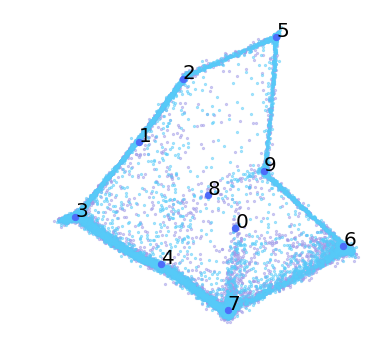

In [24]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)
#w = dec.model.get_layer('model_6').get_weights()
#cluster_centres = w[-1]
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x_train, cluster_centres, y=y_train.astype('int'), labels=labels, lcolours=[lcolours[2], lcolours[4]])

The model below outputs the soft assignments to each cluster.  The soft assignments are probablilties that each subject belongs to each cluster based on euclidean distance.  DEC determines a desirable distribution and optimizes the network such that the soft assignments match the desired distribution.  In this case we are going to assert that the desired distribution for each subject has all its weight on the closest cluster with the same label that the volunteers assigned. 

In [25]:
a = Input(shape=(400,)) # input layer
pred = dec.model(a) # 
#q = dec.model(a)
#pred = Lambda(lambda z: z[K.argmax(z, axis=1)])(q)
#pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model = Model(inputs=a, outputs=pred)
#sgd = SGD(lr=1e-3, momentum=0.9)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)
#model.compile(loss='kld', optimizer=sgd)
#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='kld', optimizer='adam')

In [26]:
x_encoded_train = dec.encoder.predict(x_train)
x_encoded_train_tiled = np.tile(x_encoded_train[:,:,np.newaxis], (1,1,dec.n_clusters))
cluster_centres = get_cluster_centres(dec).T
cluster_centres_tiled = np.tile(cluster_centres[np.newaxis,:,:], (x_train.shape[0],1,1))

In [27]:
print(x_encoded_train_tiled.shape)
print(cluster_centres_tiled.shape)

(31009, 10, 10)
(31009, 10, 10)


In [28]:
euclidean_distances = np.squeeze(K.eval(euclidean_distance((x_encoded_train_tiled, cluster_centres_tiled))))

In [29]:
euclidean_distances.shape

(31009, 10)

Find the closest clusters for each subject matching the volunteer labels.

In [30]:
cluster_preds = dec.predict_clusters(x_train)
cluster_centres = get_cluster_centres(dec)
y_train_c = []
for i in range(x_train.shape[0]):
  l = y_train[i]
  c = cluster_preds[i]
  cl = cluster_to_label_mapping[c]
  if l == cl:
    y_train_c.append(c)
  else:
    #encodedx = dec.encoder.predict(x_train[i][np.newaxis])
    ed = euclidean_distances[i][[np.where(cluster_to_label_mapping == l)]]
    ac = int(np.array(cluster_to_label_mapping)[np.where(cluster_to_label_mapping == l)][np.argmin(ed)])
    y_train_c.append(ac)

In [31]:
np_utils.to_categorical(y_train_c,n_clusters).shape # THIS SHOULD BE SHAPE (N_EXAMPLES, N_CLUSTERS)

(31009, 10)

In [32]:
m = int(.75*x_train.shape[0])
model.fit(x_train[:m], np_utils.to_categorical(y_train_c,n_clusters)[:m], \
          validation_data=(x_train[m:], np_utils.to_categorical(y_train_c,n_clusters)[m:]), epochs=4, batch_size=256)

Train on 23256 samples, validate on 7753 samples
Epoch 1/4
23256/23256 [==============================] - 9s 376us/step - loss: 1.6285 - val_loss: 1.6261
Epoch 2/4
23256/23256 [==============================] - 9s 370us/step - loss: 1.4773 - val_loss: 1.5712
Epoch 3/4
23256/23256 [==============================] - 8s 352us/step - loss: 1.3405 - val_loss: 1.5854
Epoch 4/4
23256/23256 [==============================] - 9s 376us/step - loss: 1.1858 - val_loss: 1.6108


The above quickly begins to overfit after 3 epochs.  Could try using SGD rather than adam as the optimizer.

In [33]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping_safe(y_train, y_pred, n_classes, n_clusters)

0 2297 0 0.7252938615585547
1 10346 1 0.7347767253044655
2 1042 1 0.738003838771593
3 3577 0 0.852390271176964
4 2341 0 0.7014096539940197
5 2561 1 0.6966028894962905
6 4631 0 0.5961995249406176
7 2544 0 0.8018867924528302
8 0 0 nan
9 1670 1 0.6766467065868264
[0. 1.] [0 1]
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


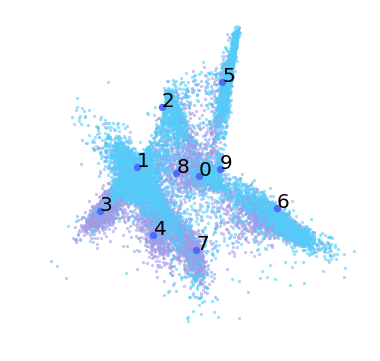

In [34]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x_train[:m], cluster_centres, y=y_train[:m].astype('int'), labels=labels, lcolours=[lcolours[2], lcolours[4]])

In [35]:
calc_f1_score(y_train.astype('int'), dec.predict_clusters(x_train), cluster_to_label_mapping)

0.7248843782117164

In [36]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_valid)
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
_, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping_safe(y_valid, y_pred, n_classes, n_clusters)

0 3540 0 0.6310734463276836
1 14759 0 0.5787654990175486
2 1572 1 0.7048346055979644
3 3999 0 0.7396849212303076
4 3843 0 0.726775956284153
5 4269 1 0.7006324666198173
6 6088 0 0.7051576872536137
7 3068 0 0.7812907431551499
8 0 0 nan
9 2830 1 0.6035335689045936
[0. 1.] [0 1]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


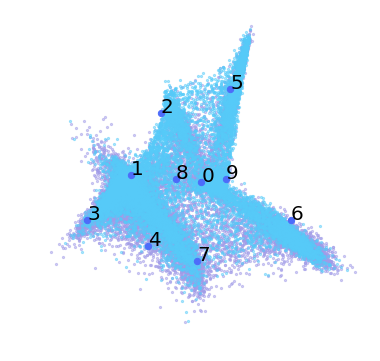

In [37]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x_valid, cluster_centres, y=y_valid.astype('int'), labels=labels, lcolours=[lcolours[2], lcolours[4]])

In [38]:
calc_f1_score(y_valid.astype('int'), dec.predict_clusters(x_valid), cluster_to_label_mapping)

0.5820364498874555